In [1]:
import torch
import torch.nn as nn




class DoubleConv(nn.Module):
    def __init__(self, input_channel, out_channel):
        super(DoubleConv, self).__init__()

        self.c1 = nn.Sequential(nn.Conv2d(input_channel, out_channel,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
        nn.BatchNorm2d(num_features=out_channel),
        nn.ReLU())
        self.c2 = nn.Sequential(nn.Conv2d(out_channel, out_channel,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
        nn.BatchNorm2d(num_features=out_channel),
        nn.ReLU())

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        return x

class UNET(nn.Module):

    def __init__(self, input_c, num_cls):
        super(UNET, self).__init__()

        self.input_channels = input_c
        self.class_num = num_cls


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoder
        self.down_conv1 = DoubleConv(self.input_channels, 64)
        self.down_conv2 = DoubleConv(64,128)
        self.down_conv3 = DoubleConv(128, 256)
        self.down_conv4 = DoubleConv(256, 512)
        self.down_conv5 = DoubleConv(512, 1024)


        # Decoder
        self.up_conv1 = DoubleConv(1024, 512)
        self.up_conv2 = DoubleConv(512, 256)
        self.up_conv3 = DoubleConv(256, 128)
        self.up_conv4 = DoubleConv(128, 64)
        
        #head
        self.conv1x1 = nn.Conv2d(64, self.class_num, 1, stride=1, padding=0)

        # Decoder part / Expansion phase
        self.conv_trans1=nn.ConvTranspose2d(in_channels=1024,
                                           out_channels=512,
                                           kernel_size=2,
                                           stride=2)

        self.conv_trans2=nn.ConvTranspose2d(in_channels=512,
                                           out_channels=256,
                                           kernel_size=2,
                                           stride=2)


        self.conv_trans3=nn.ConvTranspose2d(in_channels=256,
                                           out_channels=128,
                                           kernel_size=2,
                                           stride=2)


        self.conv_trans4=nn.ConvTranspose2d(in_channels=128,
                                           out_channels=64,
                                           kernel_size=2,
                                           stride=2)


    def forward(self, x):
        x1 = self.down_conv1(x)
        x = self.maxpool(x1)

        x2 = self.down_conv2(x)
        x = self.maxpool(x2)

        x3 = self.down_conv3(x)
        x = self.maxpool(x3)

        x4 = self.down_conv4(x)
        x = self.maxpool(x4)

        x = self.down_conv5(x)

        # Decoder Part
        #block 1
        x = self.conv_trans1(x)
        cat1 = torch.cat(tensors=(x, x4), dim=1)
        x = self.up_conv1(cat1)
        
        # block 2

        x = self.conv_trans2(x)
        cat2 = torch.cat(tensors=(x, x3), dim=1)
        x = self.up_conv2(cat2)

        # block 3

        x = self.conv_trans3(x)
        cat3 = torch.cat(tensors=(x, x2), dim=1)
        x = self.up_conv3(cat3)

        # block 4

        x = self.conv_trans4(x)
        cat4 = torch.cat(tensors=(x, x1), dim=1)
        x = self.up_conv4(cat4)
        x = self.conv1x1(x)
        return x


In [2]:
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset
import cv2

class KVASIR(Dataset):

    def __init__(self, img_pth, mask_path, transform=None):
        
        super(KVASIR, self).__init__()
        self.transform = transform
        self.images = sorted(list(Path(img_pth).iterdir()))
        
        
        self.masks = sorted(list(Path(mask_path).iterdir()))


    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = np.array(img)
        mask = Image.open(self.masks[idx]).convert('L')
        mask = np.array(mask)
        (thresh, im_bw) = cv2.threshold(mask, 128, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        #mask[mask==255.0]= 1.0 
        
        if self.transform:
            transformed = self.transform(image=img, mask=im_bw)

            img = transformed['image']
            mask = transformed['mask']
            mask = torch.unsqueeze(mask, 0).type(torch.float32)
            

        return img, mask

    def __len__(self):
        return len(self.images)

    

        





In [3]:
import torch
import torch.nn as nn
import numpy as np
import albumentations as A
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
train_transforms = A.Compose([
  A.Resize(width=256, height=256), 
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(width=256, height=256), 
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])
train_images_path_list = '/kaggle/input/mini-kvasir/images/train'
train_masks_path_list = '/kaggle/input/mini-kvasir/masks/train'
val_images_path_list = '/kaggle/input/mini-kvasir/images/val'
val_masks_path_list = '/kaggle/input/mini-kvasir/masks/val'


train_dataset=KVASIR(train_images_path_list,train_masks_path_list,train_transforms)
val_dataset=KVASIR(val_images_path_list,val_masks_path_list,val_transforms)


train_loader = DataLoader(train_dataset, batch_size= 8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 8, shuffle=False)





/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print(train_dataset[0][1].shape)

torch.Size([1, 256, 256])


In [6]:

def fit(model, device, train_loader, val_loader, optimizer, criterion, epochs, PATH):
    model = model.to(device)
    

    min_val_loss = np.Inf
    history={'train_loss':[],'val_loss':[]}

    for epoch in range(epochs):
        
        model.train()
        val_loss = 0
        train_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)

            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():

            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()

        train_loss=train_loss/len(train_loader)
        val_loss=val_loss/len(val_loader)
        
        print(f"[{epoch+1:>2d}/{epochs:>2d}], train_loss: {train_loss:>.5f}, val_loss: {val_loss:>.5f}")
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_loss<min_val_loss:
            torch.save(model.state_dict(),PATH)
        min_val_loss=val_loss
    return history


In [7]:

model = UNET(3, 1)
optimizer = torch.optim.Adam(model.parameters(),
lr= 0.001)

criterion = nn.BCEWithLogitsLoss()



device = 'cuda' if torch.cuda.is_available() else 'cpu'
history=fit(model, device, train_loader, val_loader, optimizer, criterion, epochs=50, PATH='./UNET_model.pt')





[ 1/50], train_loss: 0.42731, val_loss: 0.36544
[ 2/50], train_loss: 0.35629, val_loss: 0.33425
[ 3/50], train_loss: 0.33656, val_loss: 0.37090
[ 4/50], train_loss: 0.32415, val_loss: 0.37085
[ 5/50], train_loss: 0.32005, val_loss: 0.30369
[ 6/50], train_loss: 0.31831, val_loss: 0.31427
[ 7/50], train_loss: 0.31218, val_loss: 0.35537
[ 8/50], train_loss: 0.30882, val_loss: 0.29562
[ 9/50], train_loss: 0.30340, val_loss: 0.30194
[10/50], train_loss: 0.30329, val_loss: 0.29815
[11/50], train_loss: 0.29699, val_loss: 0.40458
[12/50], train_loss: 0.29205, val_loss: 0.27941
[13/50], train_loss: 0.28787, val_loss: 0.26154
[14/50], train_loss: 0.28301, val_loss: 0.25885
[15/50], train_loss: 0.28155, val_loss: 0.32782
[16/50], train_loss: 0.27722, val_loss: 0.30089
[17/50], train_loss: 0.27786, val_loss: 0.26149
[18/50], train_loss: 0.27764, val_loss: 0.26834
[19/50], train_loss: 0.27430, val_loss: 0.24892
[20/50], train_loss: 0.26894, val_loss: 0.32430
[21/50], train_loss: 0.26595, val_loss: 

In [11]:
test_transform = A.Compose([
    A.Resize(width=256, height=256), 
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])

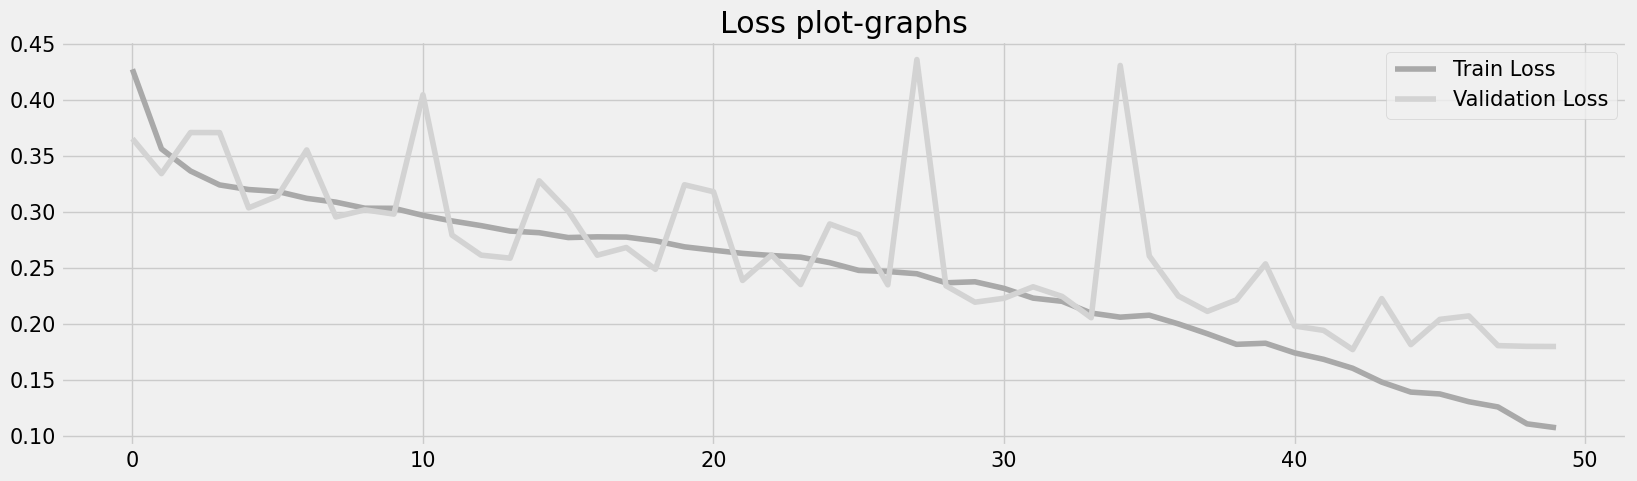

In [59]:
with plt.style.context(style='fivethirtyeight'):
    plt.figure(figsize=(18,5))
    plt.rcParams['font.size']=15
    plt.plot(list(range(50)),history['train_loss'],label='Train Loss',color='darkgray')
    plt.plot(list(range(50)),history['val_loss'],label='Validation Loss',color='lightgray')
    plt.title(label='Loss plot-graphs')
    plt.legend()
    plt.show()

In [12]:
test_images_path_list = '/kaggle/input/mini-kvasir/images/test'
test_masks_path_list = '/kaggle/input/mini-kvasir/masks/test'
test_dataset=KVASIR(test_images_path_list,test_masks_path_list,test_transform)


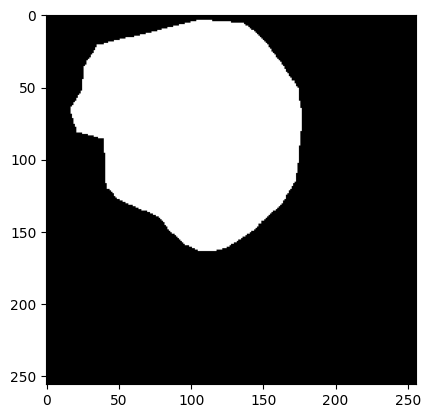

In [17]:
test_img = test_dataset[0][1].squeeze(0,1)

plt.imshow(test_img, cmap='gray')

3.4417772 -4.795732


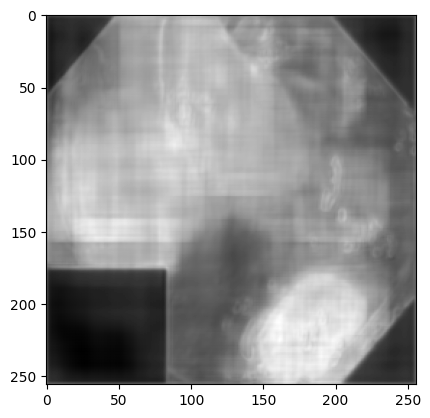

In [53]:
idx = np.random.randint(0, 99)
test_img = test_dataset[idx][0].to(device).unsqueeze(0)
result = model(test_img).squeeze(0,1).detach().cpu().numpy()
mask = test_dataset[idx][1].squeeze(0,1)
print(result.std(), result.mean())

plt.imshow(result, cmap='gray')
plt.savefig('result.png')
#plt.imshow(result, cmap='gray')

torch.Size([256, 256])


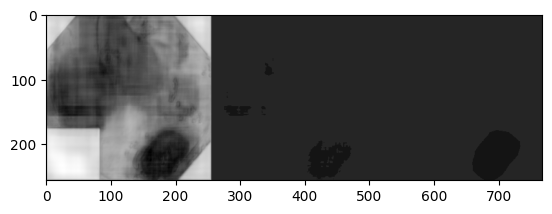

In [54]:
print(mask.shape)
t = 0.1
O = (result >= t) * 1
I = result
both = np.hstack((I, O, mask))
plt.imshow(both, cmap='binary')

In [55]:
result.min()

-12.748577